# EE5907 CA1 Part 4

1&2. Based on the code above, generate data similar to:

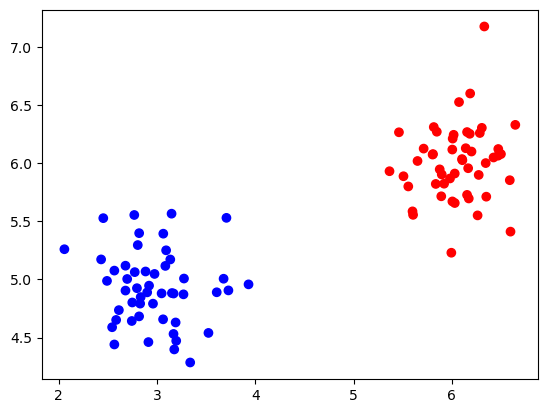

In [2]:

import numpy as np
import matplotlib.pyplot as plt

N1 = 50
N2 = 50
K = 2
sigma = 0.1

mean = (6, 6)
cov = [[sigma, 0], [0, sigma]]
X1 = np.random.multivariate_normal(mean, cov, N1)
C1 = ["red"] * len(X1)

mean = (3, 5)
cov = [[sigma, 0], [0, sigma]]
X2 = np.random.multivariate_normal(mean, cov, N1)
C2 = ["blue"] * len(X2)

# outliers
mean = (8, 6)
cov = [[sigma, 0], [0, sigma]]
X3 = np.random.multivariate_normal(mean, cov, N1)
C3 = ["blue"] * len(X3)

X = np.concatenate([X1, X2])
color = np.concatenate([C1, C2])

T = []
for n in range(0, len(X)):
    if n < len(X1):
        T.append(0)
    if (n >= len(X1) and n < len(X1) + len(X2)): 
        T.append(1)

plt.scatter(X[:, 0], X[:, 1], marker='o', c=color)
plt.show()


3. Implement the MAP for classification, so that using the above data as training, we can generate a classifier in the basis function space (a space with higher dimensionality). Show the first and second bases.

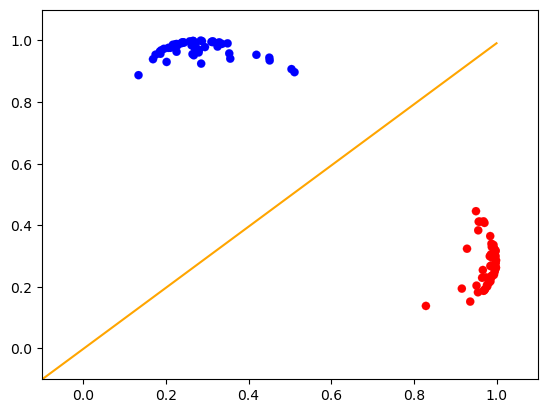

In [3]:
def gaussian(x, mean, sigma):

    gau = np.exp(-1*((x - mean)**2).sum()/(2*(sigma**2)))
    
    return gau
# gd = gaussian(X,1,1)
# print(gd)

def sigmoid(x, mu ,s):

    h = 1 / (1 + np.exp(-(x - mu)/s))

    return h

def getmean(X, m):

    mu = np.zeros((m))
    gap = (max(X) - min(X))/(m)

    for i in range(m):
        mu[i] = (i) * gap

    return mu

beta = 15
alpha = 1.5
M = 8
s = 3
epochs = 400
N = len(X)
# print(N)

def clf_plt(data, alpha, epochs, n = N):

    phi_1 = np.zeros((X.shape[0], 1))
    phi_2 = np.zeros((X.shape[0], 1))
    for row in range(X.shape[0]):
        phi_1[row, 0] = gaussian(X[row], [6, 6], 2)
        phi_2[row, 0] = gaussian(X[row], [3, 5], 2)
    # print(phi_1, phi_2)

    M_plt = 3
    s_inv = (1/alpha) * np.eye(M_plt)
    weight_plt = np.zeros((M_plt, 1))
    weight_new = np.zeros((M_plt, 1))

    phi_plt = np.zeros((N, 3))
    phi_plt[:, 0] = 1
    phi_plt[:, 1] = phi_1.ravel()
    phi_plt[:, 2] = phi_2.ravel()
    # print(phi_plt)

    for epoch in range(epochs):
        weight_plt = weight_new
        sig = sigmoid(np.dot(phi_plt, weight_plt), 0, 1)
        R = np.eye(n)

        for i in range(n):
            R[i, i] = sig[i]* (1 - sig[i])
            
        H = s_inv + np.dot(phi_plt.T, np.dot(R, phi_plt))
        grad_error = np.dot(s_inv, weight_plt) + np.dot(phi_plt.T, sig - np.array(data).reshape(-1, 1))
        weight_new = weight_plt - np.dot(np.linalg.pinv(H), grad_error)

        if grad_error.any() < 1e-4:
            break

    weight_plt = weight_new
    # print(weight)
    phi_x1 = np.linspace(-1, 1, 50)
    phi_x2 = -(weight_plt[1]* phi_x1/weight_plt[2] + weight_plt[0]/ weight_plt[2])
    # print(phi_x2)
    
    plt.scatter(phi_1, phi_2, marker='o', c=color, linewidths=0.1)
    plt.plot(phi_x1, phi_x2, color = 'orange')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.show()

clf_plt(T, alpha, epochs)


4. In the testing stage, use any other locations in the original space (in the original space with low dimensionality, in the range of 0 to 10) as the test data, and plot the predicted labels (whose values between 0 to 1) in colors.

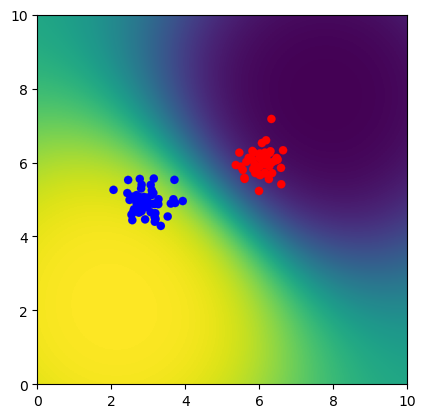

In [6]:

beta = 15
alpha = 1
M = 8
s = 3
epochs = 400

def map_clf(y_train, m, a, epochs, n = N):

    s_inv = (1/a)*np.eye(m)
    weight = np.zeros((m, 1))
    weight_new = np.zeros((m, 1))
    
    phi_mat = np.zeros((n, m))
    data_train = np.array(y_train).reshape(-1, 1)

    for row in range(n):
        for col in range(m):
            if col == 0:
                phi_mat[row, col] = 1
            else:
                phi_mat[row, col] = gaussian(X[row], 10*col/m, s)

    for epoch in range(epochs):
        weight = weight_new
        sig = sigmoid(np.dot(phi_mat, weight), 0, 1)
        R = np.eye(n)

        for i in range(n):
            R[i, i] = sig[i]* (1 - sig[i])
            
        H = s_inv + np.dot(phi_mat.T, np.dot(R, phi_mat))
        grad_error = np.dot(s_inv, weight) + np.dot(phi_mat.T, sig - data_train)
        weight_new = weight - np.dot(np.linalg.pinv(H), grad_error)
    
        if grad_error.any() < 1e-4:
            break

    weight = weight_new
    # print(weight)
    H = np.linalg.inv(H)

    return weight, H

def heat_map(weight, m):
    
    iter = 200
    hmap = np.zeros((iter,iter))

    for row in range(iter):
        for col in range(iter):
            x_test = 10 * row / iter
            y_test = 10 * col / iter
            data_test = np.array((x_test, y_test))
            phi_test = np.zeros((m, 1))

            for i in range(m):
                if i == 0:
                    phi_test[i] = 1
                else:
                    phi_test[i] = gaussian(data_test, 10 * i/m, s)
            
            label_pred = np.dot(weight.T, phi_test)
            prob = sigmoid(label_pred, 0, 1)
            hmap[iter - 1 - col, row] = prob
        
    plt.imshow(hmap, cmap = plt.cm.viridis, extent = [0, 10, 0, 10])
    plt.scatter(X[:,0], X[:,1], marker = 'o', c = color, linewidths = 0.1)
    plt.show()

w, h = map_clf(T, M, alpha, epochs)

heat_map(w, M)
